<a href="https://colab.research.google.com/github/AkasHRaJNigaM/CodeClause_Mask_detection/blob/main/Mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img , img_to_array , ImageDataGenerator
import os
import shutil
import zipfile
import xml
import random
import lxml
from bs4 import BeautifulSoup 

In [4]:
local_ref = os.path.join('/content/drive/MyDrive/Colab Notebooks/archive.zip')
zipfile_ref = zipfile.ZipFile(local_ref)
zipfile_ref.extractall('tmp')
zipfile_ref.close()

In [5]:
root_dir = os.path.join('tmp')

imgs_dir = os.path.join(root_dir , 'images')

annotations_dir = os.path.join(root_dir , 'annotations')
base_dir = os.path.join('base')

train_dir = os.path.join(base_dir , 'train') 

validation_dir = os.path.join(base_dir , 'validation')

train_with_mask_dir = os.path.join(train_dir, 'with_mask')

train_without_mask_dir = os.path.join(train_dir , 'without_mask')

validation_with_mask_dir = os.path.join(validation_dir , 'with_mask')

validation_without_mask_dir = os.path.join(validation_dir , 'without_mask')
with_mask_dir = os.path.join(root_dir , 'wtih_mask')
without_mask_dir = os.path.join(root_dir , 'without_mask')


def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
create_directory(base_dir)

create_directory(train_dir )

create_directory(validation_dir)

create_directory(train_with_mask_dir )

create_directory(train_without_mask_dir )

create_directory(validation_with_mask_dir)
create_directory(validation_without_mask_dir)
create_directory(with_mask_dir)
create_directory(without_mask_dir)


In [7]:
file_names_annotations = {}
for anno in os.listdir(annotations_dir):
    with open(os.path.join(annotations_dir,anno) , 'r') as f:
        content = f.read()
    
    content = BeautifulSoup(content , 'xml')

    if 'mask_weared_incorrect' in str(content) or 'with_mask' in str(content):
        file_names_annotations[content.find('filename').text] = 1 #means image at least has one mask 
    else:
        file_names_annotations[content.find('filename').text] = 0 #means image does not has any mask

In [8]:
def copy_file(src_path , dest_path , file_names):
    for file in file_names:
        shutil.copy(os.path.join(src_path  , file ), os.path.join(dest_path , file))
copy_file(imgs_dir , with_mask_dir , [key for key , value in file_names_annotations.items() if value == 1])
copy_file(imgs_dir , without_mask_dir , [key for key , value in file_names_annotations.items() if value == 0])

In [9]:
def split_files(src_path , train_path , validation_path , split_ratio):
    #split_size
    split_size = int(split_ratio * len(os.listdir(src_path)))
    
    train_files_selected = random.sample(os.listdir(src_path) , split_size)
    copy_file(src_path , train_path , train_files_selected)
    
    validation_files_rest = [file for file in os.listdir(src_path) if file not in train_files_selected]
    copy_file(src_path , validation_path , validation_files_rest)
split_ratio  = 0.9
split_files(with_mask_dir , train_with_mask_dir , validation_with_mask_dir , split_ratio)
split_files(without_mask_dir , train_without_mask_dir , validation_without_mask_dir , split_ratio)

In [10]:
train_gen = ImageDataGenerator(rescale = 1. / 255. , 
                              shear_range=0.2,
                              rotation_range=50 , 
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              fill_mode='nearest',
                              horizontal_flip=True,
                              vertical_flip=True)
trian_data_gen =train_gen.flow_from_directory(train_dir , 
                                             class_mode='binary',
                                             target_size=(150,150),
                                             batch_size = 128)


Found 767 images belonging to 2 classes.


In [11]:
validation_gen = ImageDataGenerator(rescale = 1. / 255. )
validation_data_gen =train_gen.flow_from_directory(validation_dir , 
                                             class_mode='binary',
                                             target_size=(150,150),
                                             batch_size = 8)

Found 86 images belonging to 2 classes.


In [12]:
from keras.applications.inception_v3 import InceptionV3
model_2 = InceptionV3(include_top = False , input_shape = (150 , 150 , 3) , weights = None)
#freezing layers for no more training
for layer in model_2.layers:
    layer.trainable = False

In [13]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-15 08:23:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M  24.8MB/s    in 4.2s    

2023-01-15 08:24:03 (20.0 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
model_2.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
model_2.summary()


In [15]:
model_2_output = model_2.get_layer('mixed10')
model_2_output_shape = model_2_output.output
x = tf.keras.layers.Flatten()(model_2_output_shape)
x = tf.keras.layers.Dense(512 , activation = 'relu')(x)
x = tf.keras.layers.Dense(1 , activation = 'sigmoid')(x)


In [16]:
pre_trained_model = tf.keras.models.Model(model_2.input , x)
pre_trained_model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer  = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4)
history_2 = pre_trained_model.fit(trian_data_gen , validation_data = validation_data_gen , epochs = 20 , callbacks = [es_callback])

Epoch 1/20
6/6 [==============================] - 56s 8s/step - loss: 13.0262 - accuracy: 0.8866 - val_loss: 5.5366 - val_accuracy: 0.9302
Epoch 2/20
6/6 [==============================] - 50s 8s/step - loss: 2.0005 - accuracy: 0.8787 - val_loss: 0.3241 - val_accuracy: 0.9302
Epoch 3/20
6/6 [==============================] - 54s 9s/step - loss: 0.2526 - accuracy: 0.9296 - val_loss: 0.2909 - val_accuracy: 0.9302
Epoch 4/20
6/6 [==============================] - 50s 8s/step - loss: 0.2635 - accuracy: 0.9296 - val_loss: 0.2313 - val_accuracy: 0.9302
Epoch 5/20
6/6 [==============================] - 51s 8s/step - loss: 0.1975 - accuracy: 0.9296 - val_loss: 0.1864 - val_accuracy: 0.9302


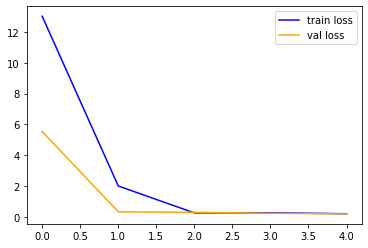

In [17]:
plt.plot(history_2.history['loss'] , 'b' , label = 'train loss')
plt.plot(history_2.history['val_loss'] , 'orange' , label = 'val loss' )
plt.legend()
plt.show()


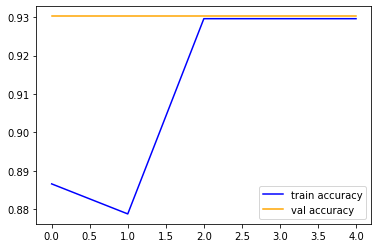

In [18]:
plt.plot(history_2.history['accuracy'] , 'b' , label = 'train accuracy')
plt.plot(history_2.history['val_accuracy'] , 'orange' , label = 'val accuracy' )
plt.legend()
plt.show()


In [19]:
pre_trained_model.evaluate(validation_data_gen)


11/11 [==============================] - 6s 547ms/step - loss: 0.1771 - accuracy: 0.9302


[0.17714524269104004, 0.930232584476471]

In [26]:
pre_trained_model.save('model.h5')